# Faryar Memon
##### ID: 14770bef0541f000 <br>
-----
#### STAGE D: Neural Network, Image Recognition & Object Detection
----- 
<br>Dataset ([Planet: Understandinf the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data))

    Dataset Description:
        - train.csv - a list of training file names and their labels, the labels are space-delimited
        - sample_submission.csv - correct format of submission, contains all the files in the test set. For more information about the submission file, please go to the Evaluation page
        - [train/test]-tif-v2.tar.7z - tif files for the training/test set (updated: May 5th, 2017)
        - [train/test]-jpg[-additional].tar.7z - jpg files for the trainin/test set (updated: May 5th, 2017)
        - Kaggle-planet-[train/test]-tif.torrent - a BitTorrent file for downloading [train/test]-tif-v2.tar.7z (updated: May 5th, 2017)
<br>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

# Import required libraries and modules

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm    # To read in images in batches and see progress
import pathlib
import scipy
import subprocess
import gc   # Garbage collector module for memory management

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2    #OpenCV for image manipulation

import tensorflow as tf
from tensorflow import keras  #We need keras library
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator  #Used for Data augmentation
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split 

# 1. Reading dataset

In [3]:
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_df.head(4)

image_name                             tags
0    train_0                     haze primary
1    train_1  agriculture clear primary water
2    train_2                    clear primary
3    train_3                    clear primary

In [4]:
test_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
test_df.head(4)

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water

# 2. Preprocessing the CSV dataset

Since the target column has multiple tags in each row, the tags are needed to undergo splitting by space and sorting through a loop for each row. Pre-processing of the dataset is referred from this [Kaggle Notebook](https://www.kaggle.com/code/okekeemmanuel/hamoye-understanding-amazon-forests-from-space).

In [5]:
label_list = []
for tag in train_df.tags.values:
    labels = tag.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
# Display label list and number of labels in the dataset
print(f'There are {len(label_list)} unique possible classes in this dataset containing {len(train_df)} records.', '\n\n' 
      f'They are {label_list}')

There are 17 unique possible classes in this dataset containing 40479 records. 

They are ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [6]:
# Creating a dictionary to map tags to integer so we encode and use them for modeling
# Assign a unique and consistent integer to each tag to be used to develop a target vector for each image with a One-hot encoding.
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))


# Creating a label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'artisinal_mine': 0, 'agriculture': 1, 'water': 2, 'conventional_mine': 3, 'bare_ground': 4, 'cloudy': 5, 'primary': 6, 'haze': 7, 'slash_burn': 8, 'partly_cloudy': 9, 'selective_logging': 10, 'cultivation': 11, 'blow_down': 12, 'clear': 13, 'habitation': 14, 'blooming': 15, 'road': 16},
 length = 17


In [7]:
# Creating a target vector by applying one hot encoding to the unique labels --- e.g [0 0 0 1 0 0 0 0 0 0] for "bare_ground" tag.
train_tag_data = train_df.copy()
for label in label_list:
    train_tag_data[label] = train_tag_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# Display head
train_tag_data.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [8]:
# Printing decreasing frequency of instances for each category
category_counts = {}

for column in train_tag_data.columns[2:]:
     category_counts[column] = train_tag_data[column].value_counts()[1]

for w in sorted(category_counts, key=category_counts.get, reverse=True):
    print(category_counts[w], w )

37513 primary
28431 clear
12315 agriculture
8071 road
7411 water
7261 partly_cloudy
4477 cultivation
3660 habitation
2697 haze
2089 cloudy
862 bare_ground
340 selective_logging
339 artisinal_mine
332 blooming
209 slash_burn
100 conventional_mine
98 blow_down


In [9]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([labels.split(" ") for labels in train_tag_data['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'artisinal_mine', 'agriculture', 'water', 'conventional_mine', 'bare_ground', 'cloudy', 'primary', 'haze', 'slash_burn', 'partly_cloudy', 'selective_logging', 'cultivation', 'blow_down', 'clear', 'habitation', 'blooming', 'road'}


# 3. Loading & Visualizing the images in training dataset

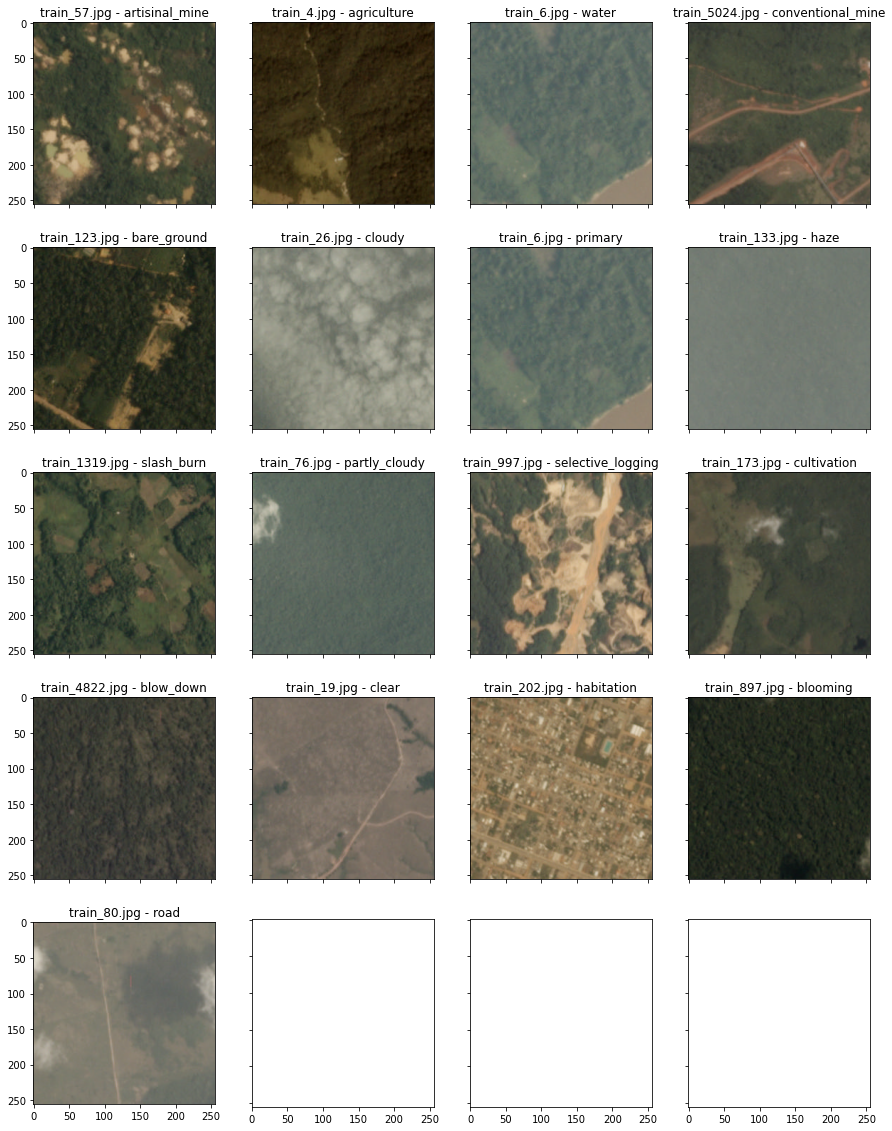

In [10]:
# Loading and visualizing one image in each category (or label) of the  training dataset using matplotlib
images = [train_df[train_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images, labels_set)):
    img = mpimg.imread('../input/planets-dataset/planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))


In [11]:
train_img_dir = pathlib.Path('../input/planets-dataset/planet/planet/train-jpg')
train_img_path = sorted(list(train_img_dir.glob('*.jpg')))


test_img_dir = pathlib.Path('../input/planets-dataset/planet/planet/test-jpg')
test_img_path = sorted(list(test_img_dir.glob('*.jpg')))


test_add_img_dir = pathlib.Path('../input/planets-dataset/test-jpg-additional/test-jpg-additional')
test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

assert len(train_img_path) == len(train_df)
print(len(test_img_path)+len(test_add_img_path))

40669


# 4.  Pre-processing

In [12]:
input_size = 64

Resizing the images using OpenCV

In [13]:
x_train = []
y_train = []

for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [03:28<00:00, 194.43it/s]


(40479, 64, 64, 3)
(40479, 17)


In [14]:
x_test = []

test_jpg_dir = '../input/planets-dataset/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]


test_jpg_add_dir = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [02:12<00:00, 155.11it/s]


(61191, 64, 64, 3)


In [15]:
X_train = x_train[ :35000]
Y_train = y_train[ :35000]

X_valid = x_train[35000: ]
Y_valid = y_train[35000: ]

# 5. Functions for Learning Curve & F beta score metric

In [16]:
# This plot will be used to plot the accuracy and loss curve

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [17]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


# 6. CNN Modelling

In [18]:
input_size = 64
input_channels = 3
batch_size = 64

In [19]:
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
#Layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
#Layer 4
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(17, activation='sigmoid'))

2022-03-22 21:10:46.752553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 21:10:46.838058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 21:10:46.839019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 21:10:46.841267: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (input_size,input_size,3), include_top = False, 
                   weights ='imagenet')
base_model.summary()

x = base_model.output
x = Flatten()(x)

x = Dense (512 , activation ='relu')(x)
predictions = Dense (17 , activation ='sigmoid')(x)
model = Model(inputs= base_model.input, outputs = predictions)

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

### 6.1 Data Augmentation

In [21]:
datagen = ImageDataGenerator (horizontal_flip=True,
                              vertical_flip=True,
                              zoom_range=0.2,
                              rotation_range=90 ,
                              fill_mode ='reflect')

### 6.2 Compiling the model

In [22]:
epochs = 20 

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [23]:
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[fbeta])

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]

### 6.3 Fitting the model

In [24]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64), 
                    steps_per_epoch=len(X_train)/64, 
                    validation_data=datagen.flow(X_valid, Y_valid, batch_size=64), 
                    validation_steps=len(X_valid)/64, 
                    epochs=epochs, callbacks=callbacks, verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-22 21:10:49.808670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-22 21:10:51.637750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


546/546 [==============================] - 64s 103ms/step - loss: 0.1539 - fbeta: 0.7896 - val_loss: 0.1269 - val_fbeta: 0.8310
Epoch 2/20
546/546 [==============================] - 56s 102ms/step - loss: 0.1200 - fbeta: 0.8354 - val_loss: 0.1189 - val_fbeta: 0.8322
Epoch 3/20
546/546 [==============================] - 56s 102ms/step - loss: 0.1126 - fbeta: 0.8459 - val_loss: 0.1086 - val_fbeta: 0.8440
Epoch 4/20
546/546 [==============================] - 55s 100ms/step - loss: 0.1080 - fbeta: 0.8520 - val_loss: 0.1087 - val_fbeta: 0.8565
Epoch 5/20
546/546 [==============================] - 56s 102ms/step - loss: 0.1056 - fbeta: 0.8556 - val_loss: 0.1088 - val_fbeta: 0.8531
Epoch 6/20
546/546 [==============================] - 55s 101ms/step - loss: 0.1038 - fbeta: 0.8585 - val_loss: 0.1034 - val_fbeta: 0.8685
Epoch 7/20
546/546 [==============================] - 55s 101ms/step - loss: 0.1024 - fbeta: 0.8611 - val_loss: 0.1064 - val_fbeta: 0.8571
Epoch 8/20
546/546 [==================

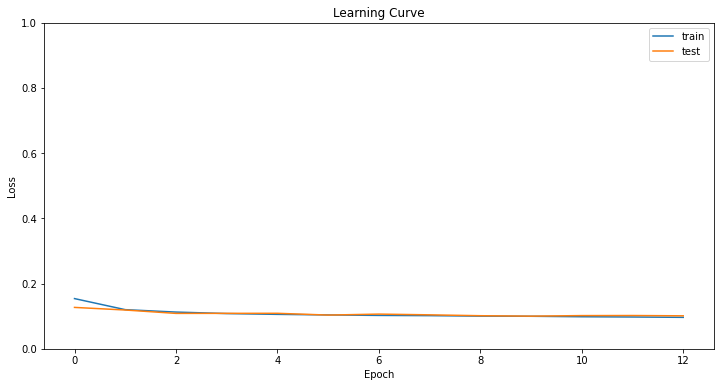

In [25]:
learning_curve(model.history, key='loss', ylim=(0,1))

# 7. Testing the model for the additional test dataset

In [26]:
test1=[]
test1.append(model.predict(x_test, batch_size=64, verbose=1))

2022-03-22 21:23:29.038886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3007660032 exceeds 10% of free system memory.
2022-03-22 21:23:32.635407: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3007660032 exceeds 10% of free system memory.


957/957 [==============================] - 11s 12ms/step


In [27]:
result = np.array(test1[0])
for i in range(1, len(test1)):
    result += np.array(test1)
result = pd.DataFrame(result, columns=labels)
result

artisinal_mine  agriculture     water  conventional_mine  bare_ground  \
0            0.000038     0.006221  0.008039       1.074401e-05     0.000269   
1            0.000022     0.005092  0.005567       3.779276e-06     0.000136   
2            0.000002     0.010096  0.030714       5.806110e-07     0.000004   
3            0.000537     0.179939  0.060390       1.959671e-04     0.005995   
4            0.000066     0.020421  0.043446       3.100889e-05     0.000310   
...               ...          ...       ...                ...          ...   
61186        0.000002     0.000312  0.000735       1.077636e-08     0.000009   
61187        0.007432     0.216726  0.969412       2.120077e-03     0.035087   
61188        0.000052     0.014035  0.244160       3.762765e-05     0.000467   
61189        0.000033     0.015565  0.113047       1.218125e-05     0.000590   
61190        0.000002     0.068898  0.102289       5.679000e-05     0.001013   

         cloudy   primary      haze    slash_burn  partly_cloudy  \
0      0.000030  0.999866  0.000323  1.744419e-04       0.003738   
1      0.000007  0.999936  0.000128  9.423670e-05       0.001196   
2      0.000081  0.999902  0.000008  3.929101e-06       0.999711   
3      0.000310  0.999031  0.000624  5.855962e-03       0.314517   
4      0.223988  0.660918  0.001575  8.989347e-05       0.809373   
...         ...       ...       ...           ...            ...   
61186  0.990247  0.004237  0.000043  1.870701e-07       0.014143   
61187  0.000195  0.986977  0.003615  7.812965e-04       0.017786   
61188  0.000025  0.999828  0.000203  3.217379e-04       0.004468   
61189  0.790748  0.092038  0.078927  1.467934e-04       0.002139   
61190  0.000002  0.887140  0.000173  7.596267e-07       0.004562   

       selective_logging  cultivation     blow_down     clear  habitation  \
0           3.491936e-03     0.002808  2.461904e-03  0.996135    0.004541   
1           4.911780e-03     0.002646  1.835942e-03  0.998513    0.007086   
2           2.748540e-05     0.000417  7.387913e-05  0.000044    0.000473   
3           6.584268e-03     0.099598  1.700280e-02  0.716206    0.015312   
4           8.100671e-05     0.002000  3.195931e-05  0.000860    0.002189   
...                  ...          ...           ...       ...         ...   
61186       9.494617e-07     0.000016  1.272257e-07  0.003096    0.034926   
61187       4.698338e-03     0.059693  4.814193e-04  0.980513    0.634476   
61188       4.975962e-03     0.006894  1.242848e-03  0.996039    0.008654   
61189       5.341634e-05     0.001143  1.402385e-05  0.080319    0.001910   
61190       4.845449e-06     0.000225  2.529887e-08  0.995194    0.999971   

           blooming      road  
0      8.135600e-02  0.006227  
1      1.189340e-01  0.004397  
2      1.086306e-04  0.004231  
3      2.714309e-02  0.030929  
4      8.224636e-05  0.022405  
...             ...       ...  
61186  4.954950e-05  0.004911  
61187  1.833033e-03  0.332295  
61188  9.738248e-03  0.113342  
61189  5.825020e-05  0.011798  
61190  1.059000e-07  0.999586  

[61191 rows x 17 columns]

In [28]:
predictions = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    predictions.append(' '.join(list(a.index))) 

100%|██████████| 61191/61191 [01:47<00:00, 567.41it/s]


## Metrics Evaluation

In [29]:
Y_pred = model.predict(X_valid, batch_size=128)
score = fbeta_score(Y_valid, np.array(Y_pred)>0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.9071917928943067
Error: 9.28%


# 8. Saving predictions to CSV

In [30]:
test_df['tags'] = predictions
test_df.to_csv('amazon_submission01.csv', index=False)